<a href="https://colab.research.google.com/github/van-dang/FEniCS-Colab/blob/master/TestODECoupling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About the code
This is a simple version of adaptive theta-method following the instructions at

https://buildmedia.readthedocs.org/media/pdf/fenics-handson/latest/fenics-handson.pdf


In [177]:
from google.colab import files

import platform, sys
python_version=platform.python_version()
from distutils.version import LooseVersion, StrictVersion

if ( LooseVersion(python_version) < LooseVersion("3.0.0")):
    print("Python3 is needed!");
    print("How to fix: Runtime/Change_runtime_type/Python 3");
    sys.exit()
    
try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from dolfin import *; from mshr import *

gmsh_dir=!which gmsh
if len(gmsh_dir)==0:
  !apt-get install gmsh
    
import matplotlib.pyplot as plt;
from IPython.display import clear_output, display; import time; import dolfin.common.plotting as fenicsplot 
import time

import os, sys, shutil

clear_output()

dolfin_version = dolfin.__version__
print ('dolfin version:', dolfin_version)

# Disable warnings
import logging
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger("rothemain.rothe_utils")
logging.getLogger('UFL').setLevel(logging.WARNING)
logging.getLogger('FFC').setLevel(logging.WARNING)

import warnings
warnings.filterwarnings("ignore")


dolfin version: 2019.1.0


t= 500.0 , elapsed time= 2.0710649490356445
3.7993704644492537e-07 5.341891088435381 1.7853571428571424


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


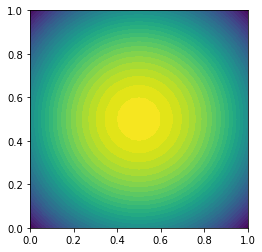

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


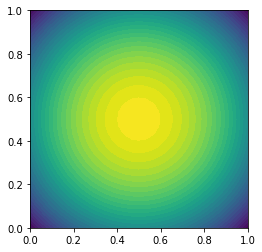

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


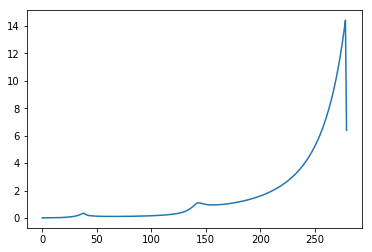

In [262]:
from fenics import *
import numpy as np

def compute_est(theta, u_L, u_H):
    """Return error estimate by Richardson extrapolation"""
    p = 2 if theta == 0.5 else 1
    est = sqrt(assemble((u_L - u_H)**2*dx)) / (2**p - 1)
    return est


def compute_new_dt(theta, est, tol, dt):
    """Return new time step"""
    p = 2 if theta == 0.5 else 1
    rho = 0.9
    dt_new = dt * ( rho * tol / est )**(1/p)
    return dt_new

  
T = 500.0            # final time
num_steps = 50     # number of time steps
dt = 0.4873170731707316 # T/num_steps       # time step size
kcoeff = 3e-3      # diffusion coefficient

# Create mesh and define function space
nx = ny = 32
mesh = UnitSquareMesh(nx, ny)
V = FunctionSpace(mesh, 'CG', 1)

t0 = 1e-1
# Define boundary condition
u_D = Expression('1/(4*k*t)*exp( (-(x[0]-x0)*(x[0]-x0)-(x[1]-y0)*(x[1]-y0))/(4*k*t) )',
                 degree=2, t=t0, x0=0.5, y0=0.5, k=kcoeff)

def boundary(x, on_boundary):
    return on_boundary

bc = DirichletBC(V, u_D, boundary)

# Define initial value
u0 = interpolate(u_D, V)


# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)

def f(t):
  return 0

J = assemble(kcoeff*dot(grad(u), grad(v))*dx)
M = assemble(u*v*dx)
b = assemble(v*dx)

linsolver = KrylovSolver("bicgstab","jacobi")
linsolver.parameters["relative_tolerance"] = 1e-6
linsolver.parameters["absolute_tolerance"] = 1e-10
linsolver.parameters["maximum_iterations"] = 100000
parameters['krylov_solver']['nonzero_initial_guess'] = True

theta = 0.5;

def single_step(theta, t, tp, dt, u, Jac, ff):
  u_D.t = t;
  Al=1./dt*M + theta*Jac;
  Ar=1./dt*M -(1-theta)*Jac;
  rhs = Ar*u.vector() + (theta*ff(t) + (1-theta)*ff(tp))*b;
  bc.apply(Al, rhs)
  u = Function(V)
  linsolver.solve(Al, u.vector(), rhs)
  return u

u = Function(V)

tp = t0;
t = tp;
tol = 1e-3;

start_time = time.time()

dt_array=[];
while t<T:
  u_low    = single_step(theta, t,          tp,  dt,   u0, J, f)
  if 1==1:
    u_mid  = single_step(theta, t + 0.5*dt, tp,  dt/2, u0, J, f)
    u_high = single_step(theta, t + dt,     tp,  dt/2, u_mid, J, f)
    est = compute_est(theta, u_low, u_high)
    dt_new = compute_new_dt(theta, est, tol, dt)
    dt_new = min(dt_new, T-t)
    # print(est, dt_new, t)
    if est > tol:
        dt = min(dt_new, T-t)
    else:
        tp = t;
        t += dt
        dt_array.append(dt)
        dt = min(dt_new, T-t)
        u0.vector()[:] = u_high.vector()[:]
  else:
    tp = t;
    t += dt
    dt_array.append(dt)
    u0.vector()[:] = u_low.vector()[:]

elapsed_time = time.time() - start_time  
print('t=',t,', elapsed time=',elapsed_time)      
u_D.t = t;
ue = interpolate(u_D,V)
est = compute_est(theta, ue, u0)
print(est, ue.vector().norm('l2'), np.mean(dt_array))

plot(ue)
plt.figure();
plot(u0)
plt.figure();
plt.plot(dt_array)